# Li building PP from GBRV rho with LDA with TF02vW

In [1]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import environ

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [3]:
from ase.atoms import Atoms
from ase.io import read

In [5]:
atoms = read('../KS/LDA/rho_ks_Li_gbrv.xsf')

In [6]:
ions, rho_ks, _ = io.read_all('../KS/LDA/rho_ks_Li_gbrv.xsf')
grid = rho_ks.grid


In [7]:
# import py3Dmol
# from ase.build import bulk
# from ase.io import write
# from ase.constraints import FixBondLength
# write('Li.xyz',ions)
# v = py3Dmol.view(data=open('./Li.xyz','r').read(), style='sphere',linked=False)

# v.addUnitCell()
# v.zoomTo()
# v.show()

In [8]:
PP_list = {'Li': '/projectsn/mp1009_1/Valeria/NLPP/PP/li_lda_v1.4.uspp.F.UPF',}

In [42]:
rho_ini =rho_ks.copy()
PSEUDO = Functional(type='PSEUDO', grid=rho_ks.grid, ions=ions, PP_list=PP_list)
core = PSEUDO.core_density ## GBRV don't have NLCC

setting key: Li -> /projectsn/mp1009_1/Valeria/NLPP/PP/li_lda_v1.4.uspp.F.UPF


In [10]:
KE = Functional(type='KEDF',name='TFvW', y=0.2)
XC = Functional(type='XC',name='LDA', core_density=core)
HARTREE = Functional(type='HARTREE')

In [11]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

In [12]:
optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
rho = opt.optimize_rho(guess_rho=rho_ks)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -1.126619386575E+00     -1.126619E+00   2.099285E+01    1       1       3.350389E-01    
1       -3.129966510095E+00     -2.003347E+00   3.611593E+00    1       2       5.114229E-01    
2       -3.223882366209E+00     -9.391586E-02   1.233727E+01    1       2       6.592584E-01    
3       -3.373458177025E+00     -1.495758E-01   1.456357E+01    1       2       8.380857E-01    
4       -3.480939404404E+00     -1.074812E-01   6.314582E+00    1       2       1.005609E+00    
5       -3.536734078513E+00     -5.579467E-02   3.653029E+00    1       2       1.183777E+00    
6       -3.561996474758E+00     -2.526240E-02   2.419699E+00    1       2       1.351837E+00    
7       -3.582809076150E+00     -2.081260E-02   1.497993E+00    1       2       1.559984E+00    
8       -3.601429691200E+00     -1.862062E-02   1.402918E+00    1       2       1.701933E+00    
9       -3.618950437397E+00   

In [13]:
delta = 0.5 * np.abs(rho_ks - rho).integral()

In [14]:
delta

1.050867420625119

In [15]:
kfmax=( np.max(rho) * 3 * np.pi )**(1.0/3.0)+0.2

In [16]:
from dftpy.mixer.pulay import PulayMixer

In [17]:
from dftpy.optimization import OESCF

In [18]:
pulay=PulayMixer(mp=None)

In [19]:
opt_options = {'econv' : 1e-6}

In [20]:
vW = Functional(type='KEDF', name='vW')
evaluator = TotalFunctional(KE=vW, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

kedf_emb = Functional(type='KEDF',name='LMGP')#, kfmax=kfmax, kfmin=1e-10, ratio=1.02)
kedf_emb.options.update({'y':0})
evaluator_emb = TotalFunctional(KEDF_EMB = kedf_emb)

opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options, optimization_method = 'CG')
opt = OESCF(optimization=opt, evaluator_emb=evaluator_emb, guess_rho=rho,mixer=pulay)

In [21]:
rho_lmgp = opt.optimize_rho(guess_rho=rho_ks, econv=1e-6)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.436695913983E-01      6.436696E-01    1.799327E+01    1       1       8.320546E-02    
1       -1.534688917534E+00     -2.178359E+00   9.334926E+00    1       3       3.164270E-01    
2       -1.819406026872E+00     -2.847171E-01   2.915017E+01    1       2       4.205692E-01    
3       -1.898821909567E+00     -7.941588E-02   3.099095E+01    1       2       5.748000E-01    
4       -1.975089136939E+00     -7.626723E-02   3.088773E+01    1       2       6.677155E-01    
5       -2.061273501068E+00     -8.618436E-02   3.346250E+01    1       2       8.232005E-01    
6       -2.130454025788E+00     -6.918052E-02   3.113252E+01    1       2       9.458320E-01    
7       -2.190896509308E+00     -6.044248E-02   1.991775E+01    1       2       1.048998E+00    
8       -2.238583264719E+00     -4.768676E-02   1.282734E+01    1       2       1.166496E+00    
9       -2.282983559056E+00   

In [22]:
delta = 0.5 * np.abs(rho_ks - rho_lmgp).integral()
print(delta)

1.0667070623141401


Text(0.5, 1.0, 'OF LMGP')

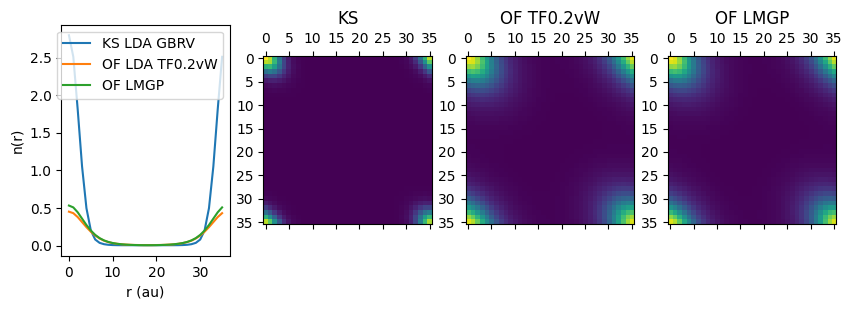

In [23]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
r = np.linspace(0,ions.cell[2][2],len(rho_ks[0,0,:].ravel()))
cut = 0
axs[0].plot(rho_ks[:,cut,cut].ravel(), label='KS LDA GBRV')
axs[0].plot(rho[:,cut,cut].ravel(), label='OF LDA TF0.2vW')
axs[0].plot((rho_lmgp[:,cut,cut]).ravel(), label='OF LMGP')
axs[0].legend()
axs[0].set_ylabel('n(r)')
axs[0].set_xlabel('r (au)')

axs[1].matshow(rho_ks[cut,:,:])
axs[1].set_title('KS')
axs[2].matshow(rho[cut,:,:])
axs[2].set_title('OF TF0.2vW')
axs[3].matshow(rho_lmgp[cut,:,:])
axs[3].set_title('OF LMGP')

In [24]:
rho.write('rho_TF02vW_Li.xsf', ions=ions)
rho_lmgp.write('rho_LMGP_Li.xsf', ions=ions)

# PP optimitization

In [25]:
def delta_pp(r, rcut, a):
    d = r - rcut
    b = (3*a[0]*rcut-4*a[1]*rcut**2+5*a[2]*rcut**3)/2.0
    v = b*d**2 + a[0]*d**3 + a[1]*d**4+a[2]*d**5
    v[r>rcut] = 0.0
    return v

def lpp2vloc(r, v, ions, grid, key, zval=0.0):
    engine = PSP(None)
    engine.r = r
    engine.v = v
    engine._zval = zval
    pseudo = LocalPseudo(grid = grid, ions=ions, PP_list={key:engine})#, MaxPoints=MaxPoints)
    pseudo.local_PP()
    return pseudo._vreal

In [28]:
key='Li'
grid = rho_ks.grid
rcut = 2.0 # Taken from the GBRV PP cutoff radius
r = np.linspace(0, rcut, 100)
a = [ 8.94735736e+00, -3.09803611e-03, -9.10081227e-01]#np.zeros(3)
# KE = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
KE = Functional(type='KEDF',name='TFvW', y=0.2)
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
ext = Functional(type='EXT')
evaluator.UpdateFunctional(newFuncDict={'EXT': ext})

optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator,optimization_options = optimization_options, optimization_method = 'CG')


rho_ini = rho_ks.copy()
environ['LOGLEVEL'] = 4
def delta_rho(a):
    print('Init')
    v = delta_pp(r, rcut, a)
    ext.v = lpp2vloc(r, v, ions, grid, key)
    rho = opt.optimize_rho(guess_rho=rho_ini)
    # rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_ks)).integral()
    # if i%50==0 and i>1:
    print('aa:', a, diff)
    return diff

In [29]:
res = minimize(delta_rho, a, method='Powell', options={'ftol': 1.0e-4})


Init
aa: [ 8.94735736e+00 -3.09803611e-03 -9.10081227e-01] 0.16691778472165245
Init
aa: [ 8.94735736e+00 -3.09803611e-03 -9.10081227e-01] 0.16691778472165245
Init
aa: [ 9.94735736e+00 -3.09803611e-03 -9.10081227e-01] 1.326333655416979
Init
aa: [ 7.32932336e+00 -3.09803611e-03 -9.10081227e-01] 1.103637632649472
Init
aa: [ 8.94735736e+00 -3.09803611e-03 -9.10081227e-01] 0.16691778472165245
Init
aa: [ 8.32932339e+00 -3.09803611e-03 -9.10081227e-01] 0.9671720728413263
Init
aa: [ 9.32932336e+00 -3.09803611e-03 -9.10081227e-01] 0.5757010015578099
Init
aa: [ 8.91208517e+00 -3.09803611e-03 -9.10081227e-01] 0.17387196197266308
Init
aa: [ 8.96217505e+00 -3.09803611e-03 -9.10081227e-01] 0.16934899360473224
Init
aa: [ 8.94339058e+00 -3.09803611e-03 -9.10081227e-01] 0.16682682258004441
Init
aa: [ 8.94384806e+00 -3.09803611e-03 -9.10081227e-01] 0.16683023367114647
Init
aa: [ 8.94277386e+00 -3.09803611e-03 -9.10081227e-01] 0.16682549727553656
Init
aa: [ 8.94286474e+00 -3.09803611e-03 -9.10081227e-01]

In [30]:
environ['LOGLEVEL'] = 2

In [43]:
a = res.x
key = 'Li'
r = PSEUDO.readpp.pp[key].r
zval = PSEUDO.readpp.pp[key]._zval
vl = PSEUDO.readpp.pp[key].v
v = delta_pp(r, rcut, a)
v += vl

engine = PSP(None)
engine.r = r
engine.v = v
engine.info['atomicnum'] = 3
engine._zval = zval

In [32]:
engine.write('PGBRV_LDA_TF02vW.psp8')
np.save('a_tf02vw.npy',a)

Text(0.5, 1.0, 'Li LPP from GBRV rho with LDA with TF02vW')

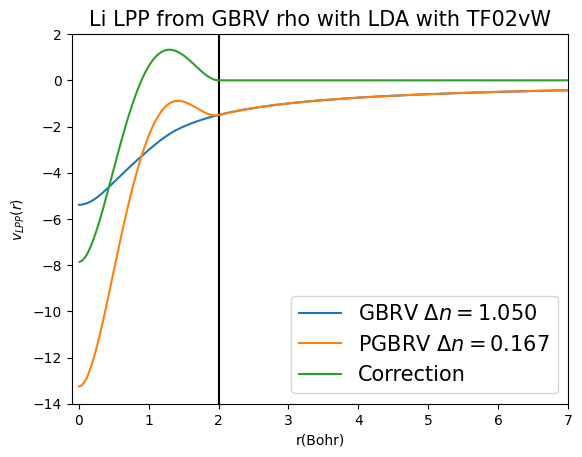

In [54]:
import matplotlib.pyplot as plt
plt.plot(r,vl, label='GBRV $\Delta n = 1.050$')
rcut = 2.0
r1=np.linspace(start=0.01,stop=10,num=1000)
# plt.plot(r,-3/(r+0.1))
#plt.scatter(np.arange(10),np.zeros(10)-4)
plt.vlines(x=rcut,ymin=-14,ymax=3,colors='k')
plt.plot(r,v, label='PGBRV $\Delta n = 0.167$')
plt.plot(r1,delta_pp(r1,rcut,a), label='Correction')
plt.ylim(-14,2)
plt.xlim(-0.1,7)
plt.xlabel('r(Bohr)')
plt.ylabel('$v_{LPP}(r)$')
plt.legend(fontsize=15)
plt.title('Li LPP from GBRV rho with LDA with TF02vW', fontsize=15)